# 100. CIFAR-10 을 이용한 CNN 구축

- **CNN**을 학습하여 CIFAR-10 데이터베이스의 이미지를 분류합니다.

<img src='https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg' width=600 />


- mean, std ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 로 normalize 된 image 의 unnormalization 방법
    - image = image * 0.5 + 0.5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Download 및 Data Loader 를 이용하여 Train, Validation data 준비

transforms.ToTensor()의 주요 특징:

1) 데이터 타입 변환: PIL 이미지나 NumPy ndarray를 torch.FloatTensor로 변환  
2) 스케일링: 이미지의 픽셀 값 범위를 [0, 255]에서 [0.0, 1.0]으로 스케일링  
3) 차원 재배열: PyTorch에서는 이미지 데이터를 [C, H, W] 형식(채널, 높이, 너비)으로 처리하므로 입력 이미지 데이터의 차원을 이 형식으로 자동 재배열

min max scaling
(X- Xmin) / (Xmax - Xmin) --> 0~1

standard scaling
(X - Xmean) / Xstd --> 평균 0, 표준편차

In [3]:
BATCH_SIZE = 32

# 이미지 데이터에 대한 변환(transform) 조합을 정의
# 이 변환은 이미지 데이터를 증강(augmentation)하고 전처리하는 과정을 포함합니다.
composed = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # 무작위로 수평 뒤집기 수행
    transforms.RandomRotation(10),    # 무작위로 최대 10도 회전
    transforms.ToTensor(),             # 이미지를 PyTorch 텐서로 변환하고 [0.0, 1.0]으로 스케일링
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 각 채널별 mean)과 std)를 사용하여 정규화 수행
])

# CIFAR10 훈련 데이터셋을 다운로드하고, 위에서 정의한 변환을 적용
train_data = datasets.CIFAR10(root='./data',
                              train=True,
                              download=True,
                              transform=composed)
# CIFAR10 테스트 데이터셋을 다운로드하고, 위에서 정의한 변환을 적용
test_data = datasets.CIFAR10(root='./data',
                             train=False,
                             download=True,
                             transform=composed)


100%|██████████| 170M/170M [00:04<00:00, 42.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

In [5]:
print(train_data)
print()
print(test_data)
print()
print(train_data[0][0].shape)
print(train_data[0][1])

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

torch.Size([3, 32, 32])
6


In [6]:
# CIFAR-10은 10개의 서로 다른 객체 클래스를 포함하는 이미지 데이터셋입니다.
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

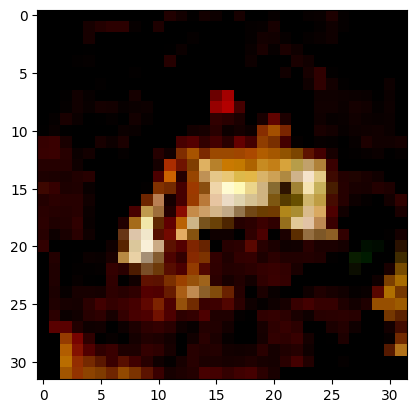

In [7]:
plt.imshow(train_data[0][0].permute(1,2,0))

### 일부 Data 시각화

- matplotlib 은 channel 위치가 last 이므로 transpose(1, 2, 0) 로 image 수정

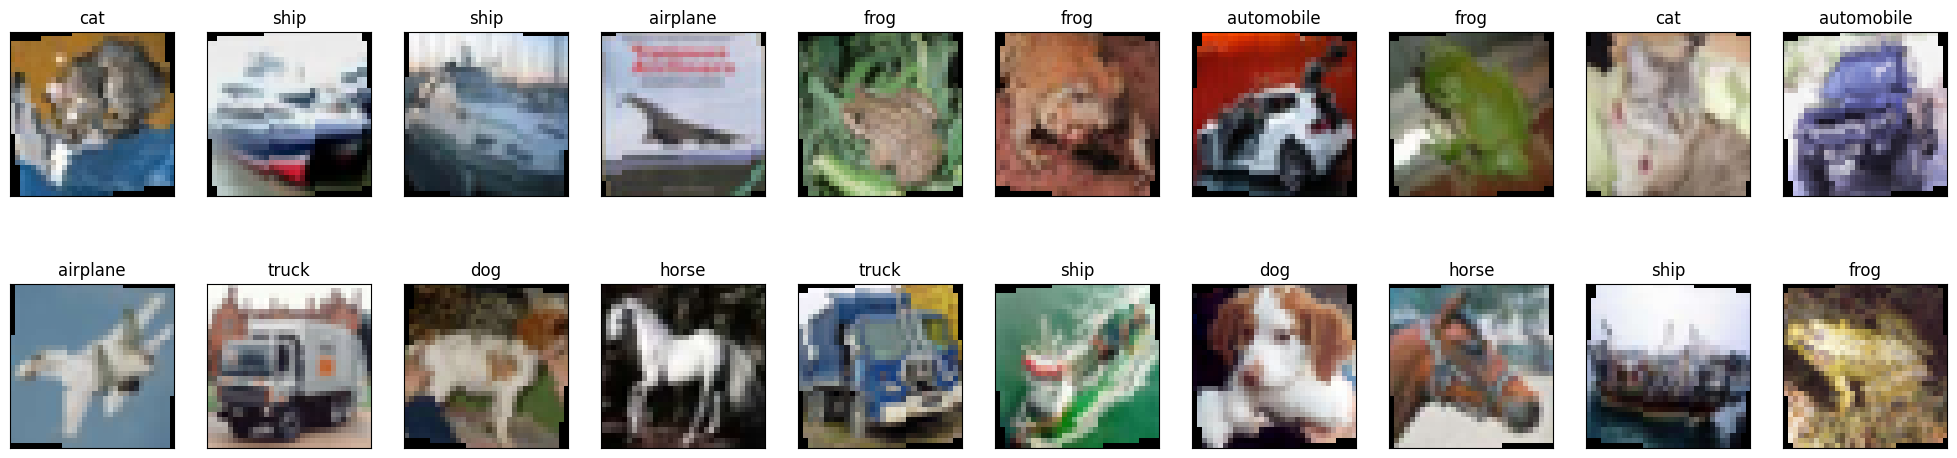

In [8]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    # np.transpose 함수를 사용하여 'x' 텐서의 차원을 재배열
    # (1, 2, 0)은 채널 차원을 마지막으로 이동시키고, 높이와 너비 차원을 앞으로 가져옵니다.
    # 이 형식은 matplotlib와 같은 일부 라이브러리에서 이미지를 표시할 때 요구되는 형식입니다.
    # * 0.5 + 0.5 연산은 정규화를 되돌려 픽셀 값을 원본 범위(0~1)로 unnormalize
    img = np.transpose(x, (1, 2, 0)) * 0.5 + 0.5

    plt.imshow(img)
    plt.title(cifar10_classes[y])
    plt.xticks([])
    plt.yticks([])

plt.imshow(img)

## Model build

### Custom Model

- Output Size = (W - F + 2P) / S + 1  
- output_size / Maxpool(2)

In [9]:
def output_size(W, F, P, S, poolsize=1):
    """
    합성곱 또는 풀링 연산 후 출력 크기를 계산하는 함수

    매개변수:
    W : 입력(feature map)의 크기 (width 또는 height)
    F : 필터(커널)의 크기
    P : 패딩(padding) 크기
    S : 스트라이드(stride) 크기
    poolsize : 풀링 크기 (기본값=1, 풀링이 없는 경우)

    반환값:
    - 풀링이 없는 경우: (W - F + 2*P) / S + 1
    - 풀링이 있는 경우: ((W - F + 2*P) / S + 1) / poolsize
    """
    size = (W - F + 2*P) / S + 1       # 합성곱 연산 후의 크기 계산
    return size if poolsize == 1 else size / poolsize  # 풀링 연산을 고려하여 최종 출력 크기 반환

input image size : (32, 32)  
kernel size : 3  
padding : 1  
stride : 1

In [10]:
# CNN의 출력 크기 변화를 단계별로 계산
out1 = output_size(32, 3, 1, 1, poolsize=2)  # 첫 번째 합성곱 + 풀링
print(out1)  # 16.0
out2 = output_size(out1, 3, 1, 1, poolsize=2)  # 두 번째 합성곱 + 풀링
print(out2)  # 8.0

out3 = output_size(out2, 3, 1, 1, poolsize=2)  # 세 번째 합성곱 + 풀링
print(out3)  # 4.0

16.0
8.0
4.0


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3개의 입력 채널을 받아 16개의 출력 채널을 생성
        # 커널 크기는 3, 패딩은 1로 설정하여 입력 이미지의 크기를 유지합니다.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)  # 첫 번째 합성곱 층의 배치 정규화

        # 16개의 입력 채널을 받아 32개의 출력 채널을 생성
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)  # 두 번째 합성곱 층의 배치 정규화

        # 32개의 입력 채널을 받아 64개의 출력 채널을 생성
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)  # 세 번째 합성곱 층의 배치 정규화

        # 첫 번째 완전 연결 층을 정의합니다. 입력 특징의 수는 4*4*64, 출력 특징의 수는 256입니다.
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc1_bn = nn.BatchNorm1d(256)  # 첫 번째 완전 연결 층의 배치 정규화
        # 두 번째 완전 연결 층을 정의합니다. 10개의 출력 클래스에 대응합니다.
        self.fc2 = nn.Linear(256, 10)

        self.maxpool = nn.MaxPool2d(2)  # 2x2 최대 풀링 층
        self.relu = nn.ReLU()  # ReLU 활성화 함수
        self.dropout = nn.Dropout(0.25)  # 드롭아웃을 통한 과적합 방지

    def forward(self, x):
        # 합성곱 층과 배치 정규화, ReLU 활성화 함수, 최대 풀링을 차례로 적용
        x = self.relu(self.conv1_bn(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.conv2_bn(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.conv3_bn(self.conv3(x)))
        x = self.maxpool(x)

        # 특징 맵을 1차원으로 평탄화
        x = torch.flatten(x, 1)   #(32, 1024)
        # 드롭아웃 적용
        x = self.dropout(x)

        # 완전 연결 층과 배치 정규화, ReLU 활성화 함수 적용
        x = self.relu(self.fc1_bn(self.fc1(x)))
        # 최종 출력 계산
        out = self.fc2(x)

        return out

### Model Summary

In [12]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [13]:
print("model parameters :", sum(p.numel() for p in model.parameters()))

model parameters : 289290


### Loss Function

회귀 - MES loss

다중분류 - catagorical cross entropy

이진분류 - binary cross entropy

In [14]:
# 학습률(Learning Rate) 설정
lr = 0.01

# 손실 함수(Loss Function) 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저(Optimizer) 설정
# - momentum=0.9: 관성을 부여하여 최적화 속도를 높이는 모멘텀 설정
# - weight_decay=1e-4: 가중치 감소(Weight Decay)로 L2 정규화 적용 (과적합 방지) -> λ
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

In [15]:
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []  # 각 에폭마다의 손실과 정확도를 저장할 리스트

EPOCHS = 10  # 전체 학습 에폭 수 설정

for epoch in range(EPOCHS):

    model.train()  # 모델을 훈련 모드로 설정

    train_loss = 0  # 한 에폭에서의 훈련 손실 누적값 초기화
    train_acc = 0   # 한 에폭에서의 훈련 정확도 누적값 초기화
    for x, y in train_loader:  # 훈련 데이터셋을 배치 단위로 순회
        x, y = x.to(device), y.to(device)  # 배치 데이터를 현재 디바이스로 이동

        optimizer.zero_grad()  # 이전 그라디언트를 초기화
        z = model(x)  # 모델을 통해 예측값 계산
        loss = criterion(z, y)  # 예측값과 실제 레이블 간의 손실 계산
        train_loss += loss.item()  # 손실 누적
        y_pred = z.argmax(1)  # 가장 높은 예측값의 인덱스를 정답으로 선택
        train_acc += (y_pred == y).sum().item()  # 정확히 예측된 개수 누적

        loss.backward()  # 손실에 대한 그라디언트 계산
        optimizer.step()  # 모델의 가중치 업데이트

    train_loss /= len(train_data)  # 평균 훈련 손실 계산
    train_acc /= len(train_data)   # 평균 훈련 정확도 계산
    LOSS.append(train_loss)
    ACC.append(train_acc)

    model.eval()  # 모델을 평가 모드로 설정

    val_loss = 0  # 검증 손실 누적값 초기화
    val_acc = 0   # 검증 정확도 누적값 초기화

    with torch.inference_mode(): #
        for x, y in test_loader:  # 테스트(검증) 데이터셋을 배치 단위로 순회
            x, y = x.to(device), y.to(device)

            z = model(x)  # 모델을 통해 예측값 계산
            loss = criterion(z, y)  # 예측값과 실제 레이블 간의 손실 계산

            val_loss += loss.item()  # 손실 누적
            val_acc += (z.argmax(1) == y).sum().item()

    # 평균 손실 및 정확도 계산
    val_loss /= len(test_data)  # 배치 단위 손실 평균
    val_acc /= len(test_data)  # 전체 샘플 개수로 나누어 정확도 계산

    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    # 에폭별 훈련 및 검증 결과 출력
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f}, validation loss: {val_loss:.5f}, train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 0.04265, validation loss: 0.03457, train acc: 0.50880, validation acc: 0.61170
epoch 1 ==> train loss: 0.03349, validation loss: 0.02975, train acc: 0.61860, validation acc: 0.65960
epoch 2 ==> train loss: 0.03021, validation loss: 0.02737, train acc: 0.66116, validation acc: 0.69890
epoch 3 ==> train loss: 0.02782, validation loss: 0.02596, train acc: 0.68738, validation acc: 0.71640
epoch 4 ==> train loss: 0.02632, validation loss: 0.02383, train acc: 0.70258, validation acc: 0.73740
epoch 5 ==> train loss: 0.02508, validation loss: 0.02269, train acc: 0.71900, validation acc: 0.74910
epoch 6 ==> train loss: 0.02406, validation loss: 0.02159, train acc: 0.72938, validation acc: 0.75920
epoch 7 ==> train loss: 0.02331, validation loss: 0.02142, train acc: 0.73994, validation acc: 0.75940
epoch 8 ==> train loss: 0.02250, validation loss: 0.02099, train acc: 0.74754, validation acc: 0.76460
epoch 9 ==> train loss: 0.02203, validation loss: 0.02090, train acc: 0.7

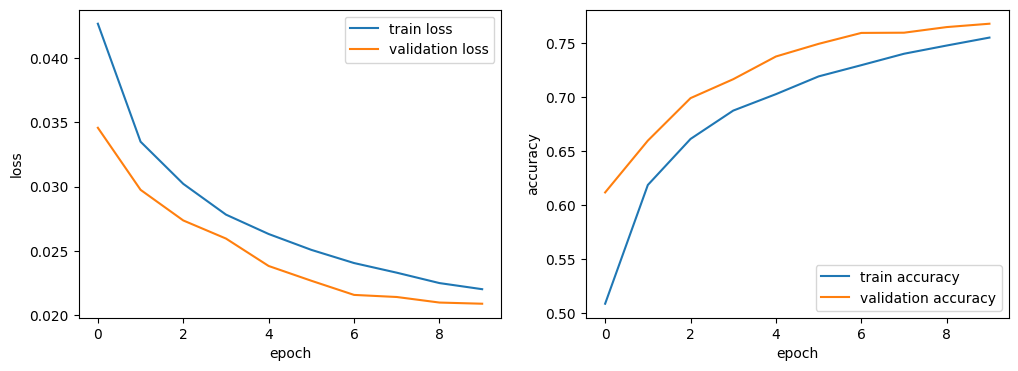

In [23]:
# 1행 2열(subplot 2개)짜리 그래프 생성, 전체 크기는 (12, 4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# (왼쪽 그래프) 학습 손실(train loss)과 검증 손실(validation loss) 그래프
ax1.plot(LOSS, label='train loss')         # 학습 데이터의 손실 그래프
ax1.plot(VAL_LOSS, label='validation loss') # 검증 데이터의 손실 그래프
ax1.set_xlabel('epoch')  # X축 라벨 (에포크)
ax1.set_ylabel('loss')   # Y축 라벨 (손실 값)
ax1.legend()             # 범례 표시

# (오른쪽 그래프) 학습 정확도(train accuracy)와 검증 정확도(validation accuracy) 그래프
ax2.plot(ACC, label='train accuracy')         # 학습 데이터의 정확도 그래프
ax2.plot(VAL_ACC, label='validation accuracy') # 검증 데이터의 정확도 그래프
ax2.set_xlabel('epoch')    # X축 라벨 (에포크)
ax2.set_ylabel('accuracy') # Y축 라벨 (정확도 값)
ax2.legend()               # 범례 표시

### Model 평가

### model 이 어떤 image 들을 잘 맞추고 혹은 틀렸는지 시각화

In [24]:
predictions = []  # 모델 예측값을 저장할 리스트
labels = []       # 실제 레이블값을 저장할 리스트

model.eval()  # 모델을 평가 모드로 설정

with torch.inference_mode():  # 메모리 최적화
    # 테스트 데이터셋을 배치 단위로 순회
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)  # 데이터를 현재 디바이스로 이동
        z = model(x)                # 모델을 통해 예측값 계산
        y_pred = z.argmax(1)  # 예측값 중 가장 높은 값을 가진 인덱스를 선택
        predictions.extend(y_pred.numpy(force=True))  # 예측된 인덱스를 CPU로 이동한 후 numpy 배열로 변환하여 predictions 리스트에 추가
        labels.extend(y.numpy(force=True))  # 실제 레이블을 CPU로 이동한 후 numpy 배열로 변환하여 labels 리스트에 추가

# 예측값과 실제 레이블이 일치하는 경우의 인덱스를 찾음
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
# 예측값과 실제 레이블이 불일치하는 경우의 인덱스를 찾음
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도 계산: 정확한 예측의 수를 전체 예측의 수로 나눈 후 100을 곱하여 백분율로 변환
accuracy = len(correct_indices) / len(predictions) * 100
print(f"accuracy = {accuracy:.2f}%")

accuracy = 76.92%


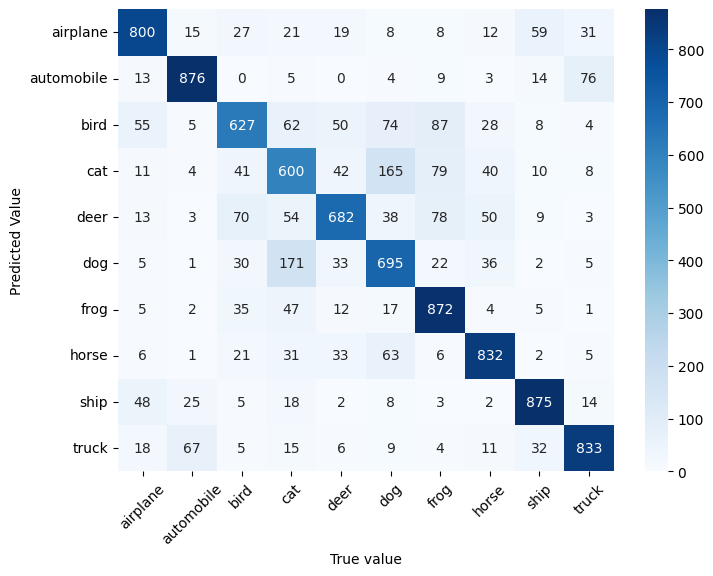

In [25]:
from sklearn.metrics import confusion_matrix  # 혼동 행렬 계산 함수
import seaborn as sns  # 시각화를 위한 라이브러리

# 혼동 행렬(Confusion Matrix) 계산
cm = confusion_matrix(labels, predictions)  # 실제 레이블과 예측값 비교하여 행렬 생성

# 혼동 행렬 시각화 (히트맵 형태)
plt.figure(figsize=(8, 6))  # 그래프 크기 설정 (가로 8, 세로 6)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  # 히트맵 스타일 지정
                 xticklabels=cifar10_classes,  # x축 클래스 레이블 설정
                 yticklabels=cifar10_classes)  # y축 클래스 레이블 설정

# 축(label) 설정
ax.set_xlabel('True value')       # x축: 실제 정답 (Ground Truth)
ax.set_ylabel('Predicted Value')   # y축: 모델의 예측값

# x축 틱 레이블을 45도 회전하여 가독성 향상
plt.xticks(rotation=45)

plt.show()

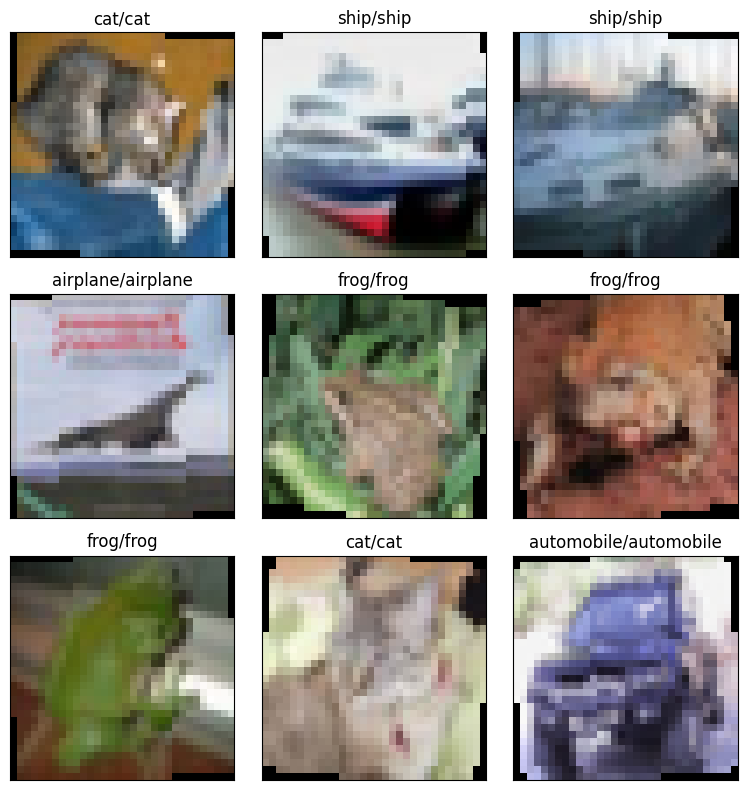

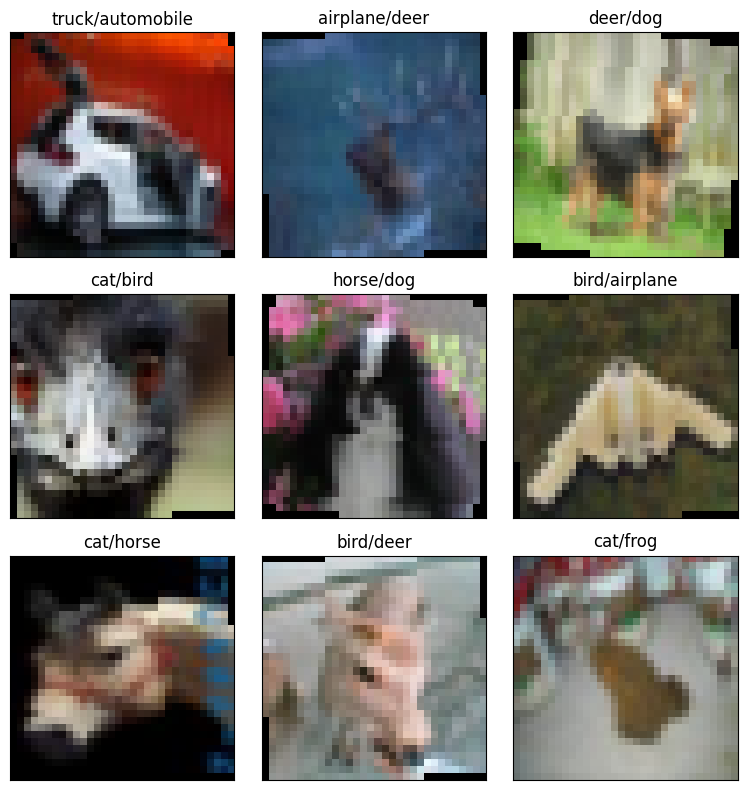

In [26]:
plt.figure(figsize=(8, 8))
# 정확한 예측의 인덱스에서 처음 9개를 순회합니다.
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5  # 이미지 정규화를 되돌리고, 차원을 재배열
    plt.imshow(img)
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))  # 예측 레이블/실제 레이블을 제목으로 표시
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거
    plt.tight_layout()  # 서브플롯 간격을 자동으로 조정

plt.figure(figsize=(8, 8))
 # 잘못된 예측의 인덱스에서 처음 9개를 순회합니다.
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5
    plt.imshow(img)
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## 모델 저장 및 불러오기  

### `state_dict` 를 사용하여 모델 저장 및 불러오기  

In [27]:
# 학습이 끝난 후 모델 가중치 저장
torch.save(model.state_dict(), "cifar10-cnn.pth")
print("학습된 모델 가중치가 저장되었습니다.")

학습된 모델 가중치가 저장되었습니다.


In [28]:
# 같은 모델 구조를 가진 새로운 모델 생성
reload_1 = Net().to(device)

# 저장된 가중치 로드
reload_1.load_state_dict(torch.load("cifar10-cnn.pth"))
print("저장된 모델 가중치를 성공적으로 로드했습니다.")

저장된 모델 가중치를 성공적으로 로드했습니다.


<ipython-input-28-94b850527bd9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reload_1.load_state_dict(torch.load("cifar10-cnn.pth"))


In [29]:
# 로드한 모델의 성능 테스트
reload_predictions = []
reload_labels = []

reload_1.eval()  # 평가 모드 설정

with torch.inference_mode():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        z = reload_1(x)
        y_pred = z.argmax(1)
        reload_predictions.extend(y_pred.cpu().numpy())
        reload_labels.extend(y.cpu().numpy())

# 정확도 계산
reload_accuracy = np.mean(np.array(reload_predictions) == np.array(reload_labels)) * 100
print(f"Reloaded model accuracy = {reload_accuracy:.2f}%")

Reloaded model accuracy = 77.40%
